In [ ]:
import warnings

warnings.filterwarnings('ignore') # To ignore all unncessary warnings

SEMANTIC TRANSFORMATION OF RESTAURANT REVIEWS (WHERE NUMERIC RATING IS PRESENT)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

model_name = "Vamsi/T5_Paraphrase_Paws"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
import boto3
import sagemaker
import pandas as pd

s3_boto3=boto3.client("s3")
sess=sagemaker.Session()
bucket="tastenet-restaurant-ranker"
obj = s3_boto3.get_object(Bucket=bucket, Key="train-data/train_V_1.csv")
df = pd.read_csv(obj['Body'])

In [ ]:
# Function to Semanticize (paraphrase) text reviews
def semantics(review):
    n=len(review)
    review="paraphrase: " + review + " </s>"
    encoding = tokenizer(
        review,
        max_length=n,           # enough for this sentence
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"].to(device)
    attention_masks = encoding["attention_mask"].to(device)

    outputs = model.generate(
    input_ids=input_ids, attention_mask=attention_masks,
    max_length=256,
    do_sample=True,
    top_k=200,
    top_p=0.95,
    early_stopping=True,
    num_return_sequences=5
    )

    line = tokenizer.decode(outputs[0], skip_special_tokens=True,clean_up_tokenization_spaces=True)
    return line

In [ ]:
from tqdm import tqdm

# Semanticize
# -----------

# Perform Sentiment analysis leveraging Bi-GRU
# --------------------------------------------

# Exploratory data analysis
# -------------------------
df_both_text_rating_reviewed = df[~df['Review'].isnull() & ~df['Rating'].isnull()]
df_only_text_review = df[~df['Review'].isnull() & df['Rating'].isnull()]
df_only_number_rated = df[df['Review'].isnull() & ~df['Rating'].isnull()]

# Paraphrasing
paraphrased_reviews=[]
for review in tqdm(df_both_text_rating_reviewed['Review'], desc="Paraphrasing Reviews"):
    paraphrased_reviews.append(semantics(review))
new_df_both_text_rating_reviewed = pd.DataFrame({'Review': paraphrased_reviews})
df_both_text_rating_reviewed.update(new_df_both_text_rating_reviewed)

In [ ]:
df_both_text_rating_reviewed.to_csv("train_V_1_Semanticized.csv",index=False)
train_prefix="train-data"
trainpath=sess.upload_data(path="train_V_1_Semanticized.csv", bucket=bucket, key_prefix=train_prefix)

SEMANTIC TRANSFORM COMPLETE

PREPARING TRANSFORMED REVIEWS FOR SENTIMENT MODEL SCORING

In [ ]:
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import unicodedata
import nltk
import tqdm
import tensorflow as tf
import contractions
import numpy as np

from nltk.tokenize import word_tokenize

print("SKLearn Version: ", sklearn.__version__)

# Exploratory data analysis
# -------------------------
df_both_text_rating_reviewed.rename(columns = {'Rating':'Sentiment'}, inplace = True)
df_both_text_rating_reviewed.info()

# 1. Ensure Sentiment is numeric
df_both_text_rating_reviewed['Sentiment'] = pd.to_numeric(df_both_text_rating_reviewed['Sentiment'], errors='coerce')

# 2. Drop rows where conversion failed
df_both_text_rating_reviewed = df_both_text_rating_reviewed.dropna(subset=['Sentiment'])

df_both_text_rating_reviewed['Sentiment'] = df_both_text_rating_reviewed['Sentiment'].round(0)

# 3. Create a new column with sentiment labels
s = df_both_text_rating_reviewed['Sentiment']

df_both_text_rating_reviewed['Sentiment'] = np.select(
    [
        (s >= 0) & (s <= 1),
        (s > 1) & (s <= 2),
        (s > 2) & (s <= 3),
        (s > 3) & (s <= 4),
        (s > 4) & (s <= 5),
    ],
    ['poor', 'negative', 'neutral', 'positive', 'good'],
    default='unknown'
)

df_both_text_rating_reviewed = df_both_text_rating_reviewed[df_both_text_rating_reviewed['Sentiment'] != 'unknown']

df_both_text_rating_reviewed.head()

# Sentiment distribution
Sentiment = df_both_text_rating_reviewed['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=Sentiment.index, y=Sentiment.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Data preparation
# ----------------

# Data cleaning
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in words if word not in list_stopwords]

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        #case folding
        doc = doc.lower()
        #remove special characters\whitespaces
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()
        #tokenize
        doc = word_tokenize(doc)
        #filtering
        doc = stopwords_removal(doc)
        norm_docs.append(doc)
    
    norm_docs = [" ".join(word) for word in norm_docs]
    return norm_docs

In [ ]:
%%time
df_both_text_rating_reviewed['Review'] = pre_process_corpus(df_both_text_rating_reviewed['Review'])

In [ ]:
df_both_text_rating_reviewed.info()

SPLITTING PREPARED REVIEWS INTO TRAINING DATA AND TESTING DATA (RATIO - 9:1)

TRAINING DATA WILL BE DIVIDED AGAIN INTO TRAINING DATA AND CROSS-VALIDATION DATA (RATIO - 9:1)

In [ ]:
import keras

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Handling imbalance (oversampling)

# Separate poor, negative, neutral, positive and good classes in training data for upsampling 
data_poor = df_both_text_rating_reviewed[df_both_text_rating_reviewed['Sentiment'] == 'poor']
data_negative = df_both_text_rating_reviewed[df_both_text_rating_reviewed['Sentiment'] == 'negative']
data_neutral = df_both_text_rating_reviewed[df_both_text_rating_reviewed['Sentiment'] == 'neutral']
data_positive = df_both_text_rating_reviewed[df_both_text_rating_reviewed['Sentiment'] == 'positive']
data_good = df_both_text_rating_reviewed[df_both_text_rating_reviewed['Sentiment'] == 'good']

print("poor class before upsample:",data_poor.shape)
print("negative class before upsample:",data_negative.shape)
print("neutral class before upsample:",data_neutral.shape)
print("positive class before upsample:",data_positive.shape)
print("good class before upsample:",data_good.shape)

# Upsample
max_size = max(data_poor.shape[0], data_negative.shape[0], data_neutral.shape[0], data_positive.shape[0], data_good.shape[0])

# sample with replacement
# to match majority class
# reproducible results

data_poor_up   = resample(data_poor, replace=True, n_samples=max_size, random_state=123)
data_negative_up = resample(data_negative, replace=True, n_samples=max_size, random_state=123)
data_neutral_up = resample(data_neutral, replace=True, n_samples=max_size, random_state=123)
data_positive_up = resample(data_positive, replace=True, n_samples=max_size, random_state=123)
data_good_up  = resample(data_good, replace=True, n_samples=max_size, random_state=123)

# Combine max class with all upsampled class
df_balance = pd.concat([data_poor_up, data_negative_up, data_neutral_up, data_positive_up, data_good_up], axis=0, ignore_index=True)
df_balance = df_balance.sample(frac=1, random_state=123).reset_index(drop=True)

# Display new class counts
print("After upsampling\n",df_balance['Sentiment'].value_counts(),sep = "")

# Data splitting (X_Test is set empty but no cross_validation_set)
# X_Test will later be df_not_number_rated
X_train_Restaurant, X_test_Restaurant, X_train , X_test, y_train, y_test = train_test_split(df_balance['Restaurant'], df_balance['Review'], df_balance['Sentiment'], test_size=0.1, random_state=42)
X_train_Restaurant.shape, X_test_Restaurant.shape, X_train.shape , X_test.shape, y_train.shape, y_test.shape

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(X_test)
t.word_index['<PAD>'] = 0

train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)

VOCAB_SIZE = len(t.word_index)

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

MAX_SEQUENCE_LENGTH = 100

# pad dataset to a maximum review length in words
X_train = keras.utils.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = keras.utils.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=5 # poor->1, negative->2, neutral->3, positive->4, good->5

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

y_train.shape, y_test.shape

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

X_train.to_csv("X_train_V_1.csv",index=False)
y_train.to_csv("y_train_V_1.csv",index=False)

train_prefix="train-data"
sess.upload_data(path="X_train_V_1.csv", bucket=bucket, key_prefix=train_prefix)
sess.upload_data(path="y_train_V_1.csv", bucket=bucket, key_prefix=train_prefix)

MODEL CREATION

In [ ]:
from sagemaker.tensorflow import TensorFlow

FRAMEWORK_VERSION = "2.19"

tf_estimator = TensorFlow( 
    entry_point="script.py",
    role="arn:aws:iam::xxxxxxxxxxxx:role/service-role/AmazonSageMaker-ExecutionRole-xxxxxxxxxxxxxxx",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    framework_version=FRAMEWORK_VERSION,
    py_version="py312",
    script_mode=True,
    output_path="s3://tastenet-restaurant-ranker",
    base_job_name="restaurant-ranker-model",
    max_run=3600,
    hyperparameters={
        "max-seq-length": MAX_SEQUENCE_LENGTH,
        "vocab-size": VOCAB_SIZE,
        "embedding-dim": 300,
        "gru-dim": 32,
        "batch-size": 128,
        "epochs": 100
    }
)

EXECUTIONG TRAINING JOB

In [ ]:
tf_estimator.fit({"train": "s3://tastenet-restaurant-ranker/train-data/"})

accuracy: 0.9633 - loss: 0.0892 - val_
accuracy: 0.8362 - val_loss: 1.8319

Saved artifact at '/opt/ml/model/1'. The following endpoints are available:
Endpoint 'serve' args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.float32, name='keras_tensor')

Output Type:
TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)

In [ ]:
training_job_name = tf_estimator.latest_training_job.name
training_job_name
model_data=tf_estimator.model_data
model_data

CREATING A PREDICTOR FOR THE TRAINED MODEL

In [ ]:
from sagemaker.tensorflow.model import TensorFlowModel

tensorflow_model = TensorFlowModel(model_data=model_data, role='arn:aws:iam::xxxxxxxxxxxx:role/service-role/AmazonSageMaker-ExecutionRole-xxxxxxxxxxxxxxx', entry_point='script.py', framework_version=FRAMEWORK_VERSION)

predictor = tensorflow_model.deploy(instance_type='ml.m5.xlarge', initial_instance_count=1)

In [ ]:
endpoint=predictor.endpoint
endpoint

MODEL EVALUATION

In [ ]:
y_train.to_numpy()
y_test.to_numpy()

In [ ]:
import numpy as np
import tensorflow as tf

# Evaluation
# ----------

def eval_err(y, yhat):
    m = len(y)
    incorrect = 0
    for i in range(m):
        ### START CODE HERE ### 
        if y[i][0]!=yhat[i]:
                incorrect+=1
    cerr=incorrect/m

    return(cerr)

# Model Accuracy

def calc_error(X,y):
    X_logits = predictor.predict(X)
    logits_predictions=X_logits['predictions']

    # Convert the NumPy array to a TensorFlow tensor
    tf_tensor = tf.constant(logits_predictions, dtype=tf.float32)

    X_probs_tensor  = tf.nn.softmax(tf_tensor, axis=1)

    # Convert the result back to a NumPy array
    X_probs=X_probs_tensor.numpy()

    # +1 for actual rating
    y_pred = np.argmax(X_probs, axis=1)

    err = eval_err(y, y_pred)
    return err, y_pred

train_error, y_train_pred=calc_error(X_train,y_train)
test_error, y_test_pred=calc_error(X_test,y_test)

# Final evaluation of the model

train_acc = 1 - train_error
test_acc = 1 - test_error
print('Train: %.2f%%, Test: %.2f%%' % (train_acc*100, test_acc*100))

TRAINING ACCURACY OBTAINED -

Train: 95.14%, Test: 84.10%

In [ ]:
y_test_pred_copy=y_test_pred.copy()

y_test_pred_copy = y_test_pred_copy.astype(str)
n=len(y_test_pred_copy)
for i in range(n):
    if y_test_pred_copy[i]=='0':
        y_test_pred_copy[i]='poor'
    elif y_test_pred_copy[i]=='1':
        y_test_pred_copy[i]='negative'
    elif y_test_pred_copy[i]=='2':
        y_test_pred_copy[i]='neutral'
    elif y_test_pred_copy[i]=='3':
        y_test_pred_copy[i]='positive'
    else:
        y_test_pred_copy[i]='good'

In [ ]:
y_test_copy=y_test.copy()
y_test_copy=y_test_copy.astype(str)
n=len(y_test_copy)
for i in range(n):
    if y_test_copy[i][0]=='0':
        y_test_copy[i][0]='poor'
    elif y_test_copy[i][0]=='1':
        y_test_copy[i][0]='negative'
    elif y_test_copy[i][0]=='2':
        y_test_copy[i][0]='neutral'
    elif y_test_copy[i][0]=='3':
        y_test_copy[i][0]='positive'
    else:
        y_test_copy[i][0]='good'

In [ ]:
sentiments=['poor','negative','neutral','positive','good']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test_copy, y_test_pred_copy, labels=sentiments))
cm = confusion_matrix(y_test_copy, y_test_pred_copy, labels=sentiments)
pd.DataFrame(cm, index=sentiments, columns=sentiments)        

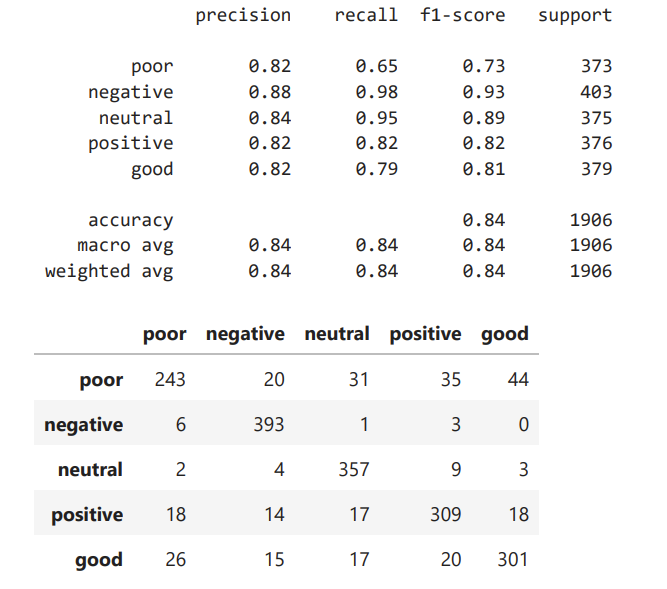

PREDICTING UNKNOWN NUMERIC RATINGS FROM TEXT REVIEWS

In [ ]:
import tqdm

# Preprocess Review to be predicted to rating
# -------------------------------------------
def preprocess_review(X):
    # Paraphrasing
    paraphrased_reviews=[]
    for review in tqdm.tqdm(X, desc="Paraphrasing Reviews"):
        paraphrased_reviews.append(semantics(review))
    new_df = pd.DataFrame({'Review': paraphrased_reviews})
    X_test = pre_process_corpus(new_df['Review'])

    t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
    # fit the tokenizer on the documents
    t.fit_on_texts(X_test)
    t.word_index['<PAD>'] = 0

    test_sequences = t.texts_to_sequences(X_test)

    VOCAB_SIZE = len(t.word_index)

    MAX_SEQUENCE_LENGTH = 100

    # pad dataset to a maximum review length in words
    X_test = keras.utils.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)

    return X_test

X_pred=preprocess_review(df_only_text_review['Review'])

X_logits = predictor.predict(X_pred)
logits_predictions=X_logits['predictions']

# Convert the NumPy array to a TensorFlow tensor
tf_tensor = tf.constant(logits_predictions, dtype=tf.float32)

X_probs_tensor  = tf.nn.softmax(tf_tensor, axis=1)

# Convert the result back to a NumPy array
X_probs=X_probs_tensor.numpy()

# +1 for actual rating
y_pred = np.argmax(X_probs, axis=1)

y_pred = y_pred + 1

df_only_text_review['Rating']=y_pred.astype(int)

df_both_text_rating_reviewed.rename(columns = {'Sentiment':'Rating'}, inplace = True)

df_both_text_rating_reviewed = df_both_text_rating_reviewed.replace({'Rating' : {'poor':1, 'negative':2, 'neutral':3, 'positive':4, 'good':5 }})

final_df=pd.concat([df_both_text_rating_reviewed, df_only_text_review, df_only_number_rated], axis=0, ignore_index=True)

df_only_text_review['Rating']=None
df_only_text_review.info()
df_only_number_rated.info()
df_both_text_rating_reviewed.info()
final_df.info()
final_df.head()

SUMMARIZING ALL REVIEWS OF EACH RESTAURANT INTO 1 SUMMARY

In [ ]:
# Restaurant summary

import nltk
import math

from typing import List, Dict, Optional
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import minmax_scale

nltk.download('punkt', quiet=True)
nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

def compute_intensity_scores(df: pd.DataFrame,
                             text_col: str = "text",
                             stars_col: str = "stars",
                             star_weight: float = 0.6) -> pd.Series:
    """
    Compute intensity score in [0,1] for each review:
      star_norm = (stars - 1) / 4  -> maps [1,5] -> [0,1]
      sent_norm = (vader_compound +1)/2  -> maps [-1,1] -> [0,1]
      intensity = star_weight * star_norm + (1-star_weight) * sent_norm
    Returns pd.Series aligned to df.index
    """
    stars = df[stars_col].astype(float).clip(1.0, 5.0)
    star_norm = (stars - 1.0) / 4.0

    def sent_norm(text):
        if not isinstance(text, str) or text.strip() == "":
            return 0.5
        c = sia.polarity_scores(text).get("compound", 0.0)
        return (c + 1.0) / 2.0

    sent_norm_vals = df[text_col].fillna("").astype(str).apply(sent_norm)
    intensity = star_weight * star_norm + (1.0 - star_weight) * sent_norm_vals
    intensity = np.clip(intensity.values, 0.0, 1.0)
    return pd.Series(intensity, index=df.index)

def _embed_sentences(sentences: List[str], model: SentenceTransformer, batch_size: int = 64):
    """Return normalized embeddings (numpy array) for a list of sentences."""
    if len(sentences) == 0:
        return np.zeros((0, model.get_sentence_embedding_dimension()), dtype=float)
    embs = model.encode(sentences, batch_size=batch_size, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
    return embs

def build_restaurant_summaries_with_stats(df: pd.DataFrame,
                                          restaurant_col: str = "Restaurant",
                                          text_col: str = "Review",
                                          stars_col: str = "Rating",
                                          sbert_model_name: str = "all-MiniLM-L6-v2",
                                          star_weight: float = 0.6,
                                          alpha: float = 0.7,
                                          beta: float = 0.25,
                                          gamma: float = 0.05,
                                          prefer_consistent: bool = True,
                                          top_k_sentences: int = 3,
                                          min_sent_len: int = 15,
                                          max_reviews_per_restaurant: int = 1000,
                                          sentence_level: bool = True
                                          ) -> Dict[str, Dict]:
    """
    Parameters:
      - alpha: weight for semantic similarity (0..1)
      - beta: weight for sentence intensity contribution (0..1)
      - gamma: optional small weight to incorporate restaurant mean intensity (positive means boost for higher-mean restaurants)
               alpha + beta + (abs(gamma) optional) should be <= 1 (gamma used multiplicatively below)
      - prefer_consistent: when True, reduce influence of sentence intensity for restaurants with high variance.
                           consistency_factor = 1 - var_norm (so high variance -> small factor)
      - top_k_sentences: number of sentences to include in summary
      - max_reviews_per_restaurant: cap reviews to process per restaurant to limit computation
    Returns:
      dict mapping business_id -> summary dict (see docstring top)
    """

    # basic assertions
    assert 0.0 <= alpha <= 1.0 and 0.0 <= beta <= 1.0
    assert alpha + beta <= 1.0 + 1e-6

    # copy minimal columns
    df_local = df[[restaurant_col, text_col, stars_col]].copy().reset_index(drop=False).rename(columns={'index':'orig_index'})

    # compute intensity per review
    df_local['intensity'] = compute_intensity_scores(df_local, text_col=text_col, stars_col=stars_col, star_weight=star_weight)

    # pre-load SBERT
    sbert = SentenceTransformer(sbert_model_name)

    summaries: Dict[str, Dict] = {}
    grouped = df_local.groupby(restaurant_col)

    for res, group in grouped:
        # compute restaurant-level stats on intensity
        intens_arr = group['intensity'].values
        mean_int = float(np.mean(intens_arr)) if len(intens_arr)>0 else 0.0
        var_int = float(np.var(intens_arr, ddof=0)) if len(intens_arr)>1 else 0.0
        n_reviews = len(group)

        # collect candidate sentences from reviews (cap reviews to avoid explosion)
        sentences: List[str] = []
        sent_review_idx: List[int] = []
        sent_review_pos: List[int] = []
        sent_intensity: List[float] = []
        # limit reviews processed (heuristic: sample if too many)
        if n_reviews > max_reviews_per_restaurant:
            # sample top reviews by stars (or you can random sample)
            limited = group.sample(max_reviews_per_restaurant, random_state=42)
        else:
            limited = group

        for _, row in limited.iterrows():
            text = str(row[text_col])
            orig_idx = int(row['orig_index'])
            intensity_val = float(row['intensity'])
            sents = sent_tokenize(text)
            for i_sent, s in enumerate(sents):
                s_clean = s.strip()
                if len(s_clean) < min_sent_len:
                    continue
                sentences.append(s_clean)
                sent_review_idx.append(orig_idx)
                sent_review_pos.append(i_sent)
                sent_intensity.append(intensity_val)

        if len(sentences) == 0:
            summaries[res] = {
                "summary": "",
                "meta": {"mean_intensity": mean_int, "var_intensity": var_int, "n_reviews": n_reviews},
                "top_sentences": []
            }
            continue

        # compute sentence embeddings (normalized)
        sent_embs = _embed_sentences(sentences, sbert)

        # restaurant centroid: mean of sentence embeddings
        rest_emb = sent_embs.mean(axis=0, keepdims=True)
        rest_emb = rest_emb / np.linalg.norm(rest_emb, axis=1, keepdims=True)

        # cosine similarity (since normalized)
        sims = (sent_embs @ rest_emb.T).squeeze()  # shape (n_sentences,)

        # normalize sims to [0,1]
        sims_norm = minmax_scale(sims)

        # normalize intensities for sentences
        intens_norm = minmax_scale(np.array(sent_intensity)) if len(sent_intensity) > 1 else np.array(sent_intensity)

        # consistency factor from variance: higher variance -> lower consistency (0..1)
        # var is in [0,1] because intensities are 0..1; normalize var to [0,1] by clamping to [0,0.25] typical max
        # but we will scale var_norm = min(var_int / 0.25, 1.0). You can tune denominator if you expect different spread.
        var_norm = min(max(var_int / 0.25, 0.0), 1.0)
        consistency_factor = 1.0 - var_norm if prefer_consistent else 1.0  # if prefer_consistent, reduce intensity influence when var is high

        # incorporate restaurant mean optionally as small multiplicative boost (centered at 0.5)
        mean_boost = 1.0 + gamma * (mean_int - 0.5)  # if mean > 0.5 -> slight boost; if <0.5 -> slight downscale

        # final importance score per sentence:
        # importance = alpha * sims_norm + beta * (intens_norm * consistency_factor * mean_boost)
        importance = alpha * sims_norm + beta * (intens_norm * consistency_factor * mean_boost)

        # If leftover weight (1 - alpha - beta) exists, it is unused; you could add other signals there.
        # Select top-k unique sentences by importance
        top_idx = list(np.argsort(importance)[-top_k_sentences:][::-1])
        top_sentences = []
        seen_texts = set()
        for idx in top_idx:
            s = sentences[idx]
            if s in seen_texts:
                continue
            seen_texts.add(s)
            top_sentences.append((s, float(importance[idx]), int(sent_review_idx[idx]), float(sent_intensity[idx])))

        # Compose final summary: join top sentences in importance order
        top_sentences_sorted = sorted(top_sentences, key=lambda x: -x[1])
        summary_text = " ".join([t[0] for t in top_sentences_sorted])

        summaries[res] = {
            "summary": summary_text,
            "meta": {"mean_intensity": mean_int, "var_intensity": var_int, "n_reviews": n_reviews},
            "top_sentences": top_sentences_sorted
        }

    return summaries

summaries = build_restaurant_summaries_with_stats(final_df, top_k_sentences=10)
data={'Restaurant':[], 'Summary':[]}
for res, info in summaries.items():
    data['Restaurant'].append(res)
    data['Summary'].append(info['summary'])

restaurant_df = pd.DataFrame(data)

In [ ]:
'''
Why Two Restaurants Have Similar Average Ratings Might have different Credible Rating ?

Example:
Restaurant	    Avg Rating	    Review Count	Rating Based On Spread	    Final Ranking
A	            4.2	            180	            0.82  (Narrow)	            High
B	            4.2	            32	            0.54  (Wide)	            Lower

1 -
Although Restaurants A and B have identical average ratings (4.2), the model ranks A much higher because
its reviews contain consistently positive sentiment, it has more reviews (more reliable),
and the rating distribution is tighter (low variance).

2 -
A high spread means users have polarising experiences (good + terrible).
A narrow spread means predictable quality.
Consumers typically prefer consistency, so the ranking should reflect stability, not only the arithmetic mean.

This demonstrates that average rating alone is insufficient for real ranking.
'''

RANKING RESTAURANTS BASED ON CONFIDENCE SCORE WHICH IS OBTAINED BY INTEGRATING COMPONENTS LIKE -

1-AVERAGE RATINGS

2-STANDARD DEVIATION i.e. SPREAD OF RATINGS, AND

3-REVIEW COUNT

In [ ]:
'''
Comparing 4.8 star (average of 100 reviews) to 4.9 star (weighted average of 30 reviews) -
----------------------------------------------------------------------------------------
Use Confidence Intervals

Apply statistical confidence interval formulas to derive the reliability of each average score:

Standard Error = σ/(n^(-0.5))
Where σ is estimated std deviation (could use 1 if unknown), and n is number of reviews.

Lower standard error means more confidence. You can even display or sort by "lower bound of confidence interval"

Lower Bound = Mean − 1.96×Standard Error
'''

# Ensure Rating is numeric
final_df = final_df.dropna(subset=['Rating'])
final_df['Rating'] = pd.to_numeric(final_df['Rating'], errors='coerce')

print(final_df.shape)

# Group by restaurant
group = final_df.groupby('Restaurant')['Rating']

Restaurant_mean = group.mean()
Restaurant_std = group.std()

print(Restaurant_mean.shape)
print(Restaurant_std.shape)

Restaurant_mean_sqrt=np.sqrt(Restaurant_mean)

print(Restaurant_mean_sqrt)

Restaurant_std_err=Restaurant_std.div(Restaurant_mean_sqrt)

print(Restaurant_std_err)

Restaurant_confidence_lower_bound=Restaurant_mean-1.96*Restaurant_std_err

print(Restaurant_confidence_lower_bound)
print(Restaurant_confidence_lower_bound.info())

In [ ]:
Restaurant_confidence_lower_bound=Restaurant_confidence_lower_bound.to_frame()

In [ ]:
Restaurant_confidence_lower_bound.info()

In [ ]:
Restaurant_confidence_lower_bound.head()

In [ ]:
restaurant_new_df=pd.merge(restaurant_df, Restaurant_confidence_lower_bound, on='Restaurant')

In [ ]:
restaurant_new_df.head()

In [ ]:
restaurant_new_df.sort_values(by='Rating',ascending=False)

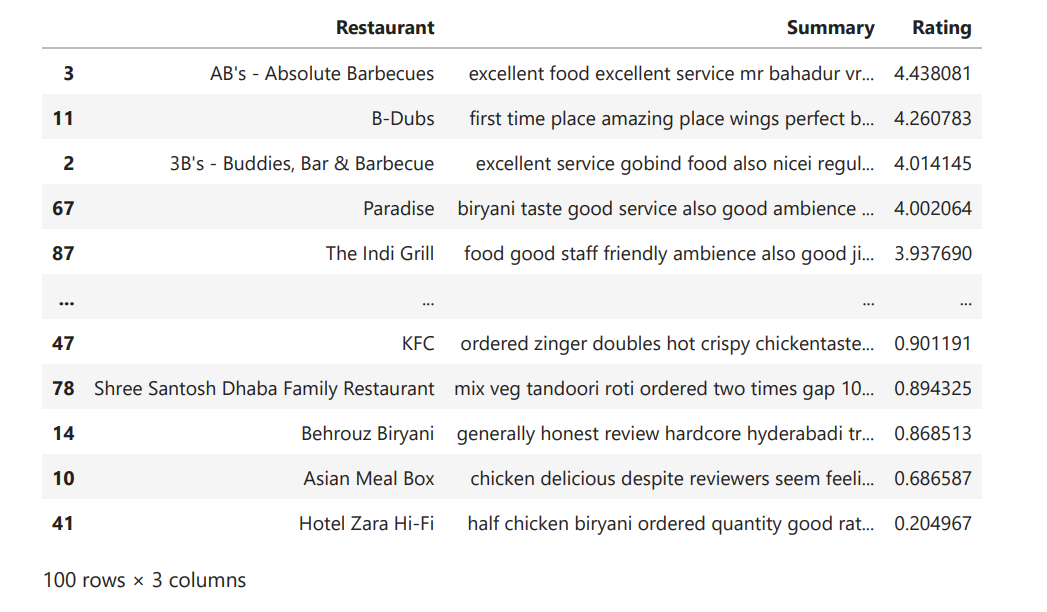

VISUAL ANALYSIS OF RESULTS

In [ ]:
'''
Hover on any bubble → restaurant name, both ranks, review count, spread, distance to diagonal.

Zoom & pan to inspect crowded regions.

Diagonal line still shows perfect agreement.

Vertical connector lines show deviation from the diagonal.

Distance numbers float above each point, same as in Matplotlib.

Legend entries with “50 / 200 / 500 reviews” show how bubble size maps to review count.

Colorbar explains that darker color = higher spread (less stable rating).
'''

import plotly.graph_objects as go

restaurants = restaurant_new_df['Restaurant'].to_numpy()
rank_avg = Restaurant_mean.to_numpy()                       # Rank by Avg Rating
rank_conf = restaurant_new_df['Rating'].to_numpy()              # Rank by Confidence Rating
rating_count = group.size()    # Review count (size of point)
spread = Restaurant_std.to_numpy()                          # Standard deviation

# Normalize sizes for bubble scaling (similar to Matplotlib)
sizes = 60  # 60 is a good size scale in Plotly

# Perpendicular distance from point to y = x
distances = np.abs(rank_conf - rank_avg) / np.sqrt(2)

# ---------- MAIN SCATTER TRACE ----------
scatter_trace = go.Scatter(
    x=rank_avg,
    y=rank_conf,
    mode="markers+text",
    text=[f"{d:.2f}" for d in distances],         # distance label
    textposition="top center",
    marker=dict(
        size=sizes,
        color=spread,
        colorscale="Inferno",
        showscale=True,
        colorbar=dict(
            title="Rating Spread (Std Dev)<br>darker = higher spread"
        ),
        line=dict(color="black", width=1)
    ),
    hovertext=[
        f"Restaurant: {r}<br>"
        f"Rank by Avg: {ra}<br>"
        f"Rank by Confidence: {rc}<br>"
        f"Reviews: {c}<br>"
        f"Spread: {s}<br>"
        f"Distance to diagonal: {d:.2f}"
        for r, ra, rc, c, s, d in zip(restaurants, rank_avg, rank_conf,
                                      rating_count, spread, distances)
    ],
    hoverinfo="text",
    name="Restaurants"
)

# ---------- VERTICAL CONNECTOR LINES ----------
connector_traces = []
for x, y in zip(rank_avg, rank_conf):
    connector_traces.append(
        go.Scatter(
            x=[x, x],
            y=[x, y],     # vertical line from diagonal y=x to actual point
            mode="lines",
            line=dict(color="gray", width=1),
            hoverinfo="skip",
            showlegend=False
        )
    )

# ---------- SIZE LEGEND (FAKE POINTS) ----------
size_legend_values = [50, 200, 500]
size_legend_traces = []
for val in size_legend_values:
    size_legend_traces.append(
        go.Scatter(
            x=[None],  # dummy, not plotted on axes
            y=[None],
            mode="markers",
            marker=dict(
                size=val / max(rating_count) * 60,
                color="gray",
                opacity=0.5
            ),
            legendgroup="review_count",
            showlegend=True,
            name=f"{val} reviews",
            hoverinfo="skip"
        )
    )

# ---------- DIAGONAL LINE ----------
max_rank = max(max(rank_avg), max(rank_conf))
diagonal_trace = go.Scatter(
    x=[1, max_rank],
    y=[1, max_rank],
    mode="lines",
    line=dict(color="gray", dash="dash"),
    name="Perfect agreement (y = x)",
    hoverinfo="skip"
)

# ---------- BUILD FIGURE ----------
fig = go.Figure()

# Add traces in order
fig.add_trace(diagonal_trace)
for t in connector_traces:
    fig.add_trace(t)
fig.add_trace(scatter_trace)
for t in size_legend_traces:
    fig.add_trace(t)

# ---------- LAYOUT ----------
fig.update_layout(
    title="Rank Comparison: Avg Rating vs Statistical Confidence (Interactive)",
    xaxis=dict(
        title="Rank by Avg Rating",
        autorange="reversed",   # Rank 1 on left
        range=[0.5, max_rank + 0.5]
    ),
    yaxis=dict(
        title="Rank by Confidence Rating",
        autorange="reversed",   # Rank 1 on top
        range=[0.5, max_rank + 0.5]
    ),
    legend=dict(
        title="Point Size = Review Count",
        x=1.02,
        y=1,
        bordercolor="lightgray",
        borderwidth=1
    ),
)

fig.show()

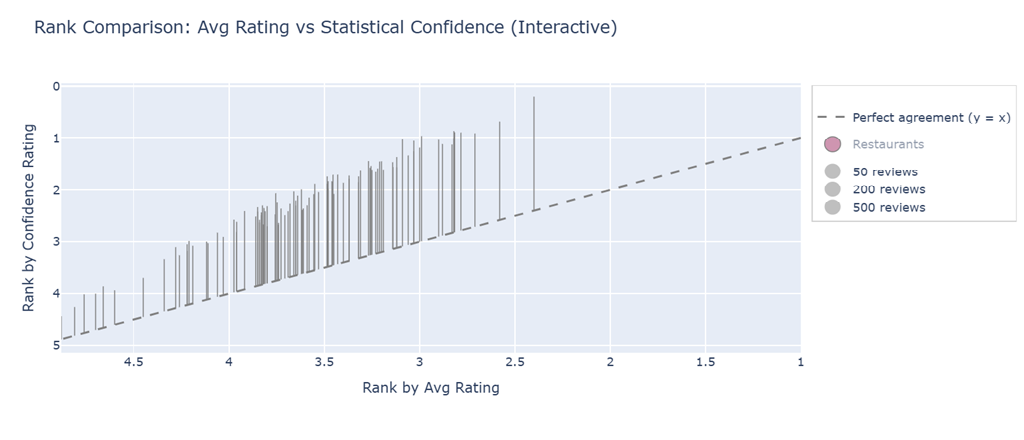

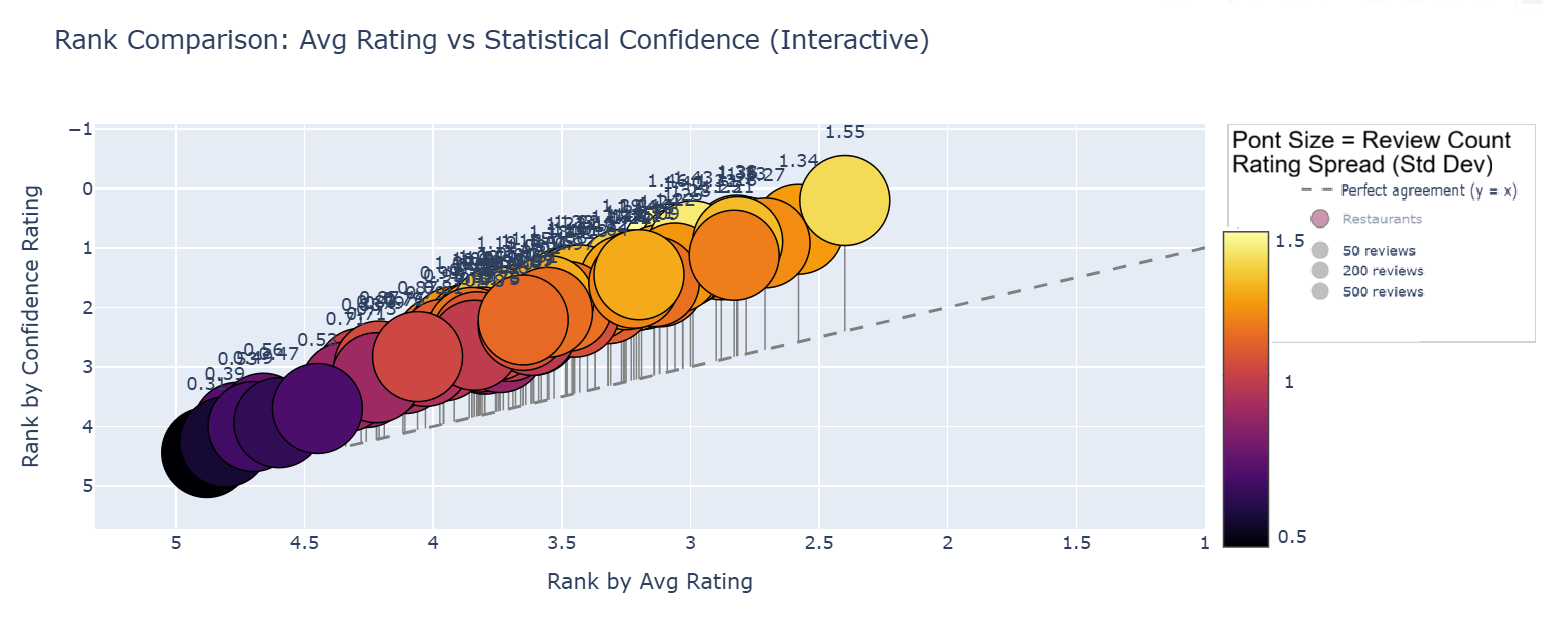

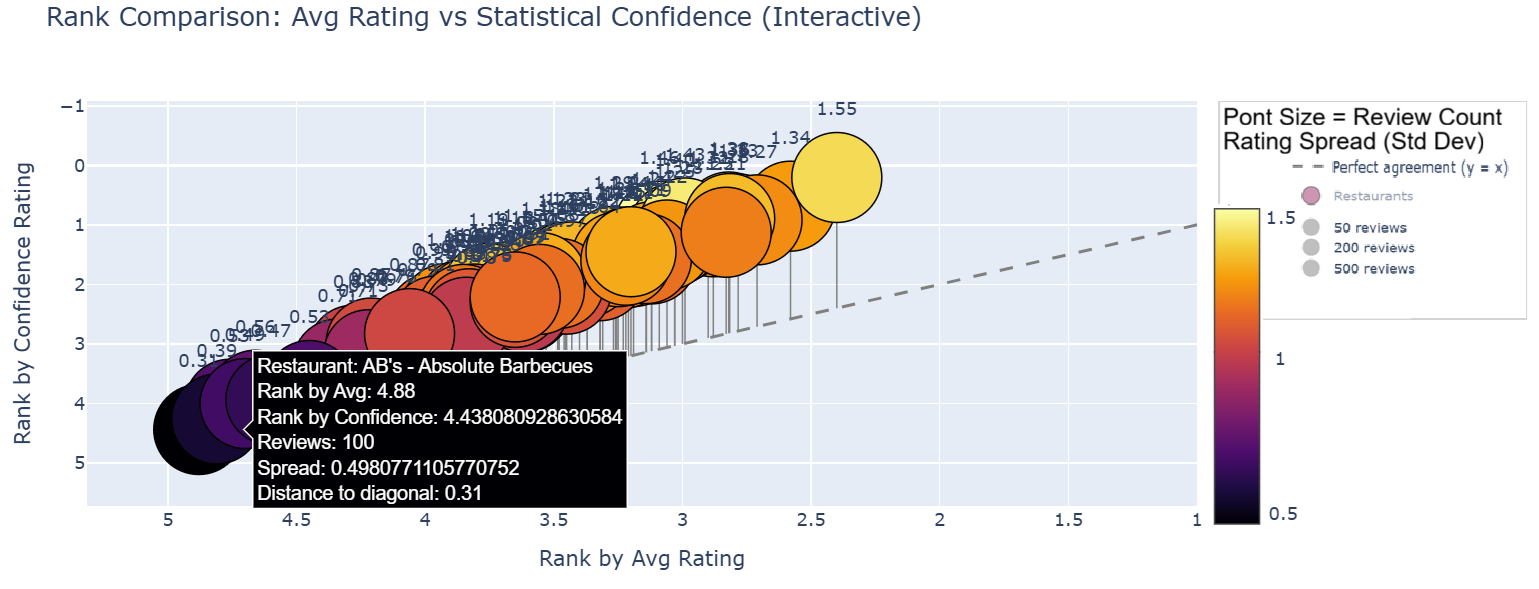

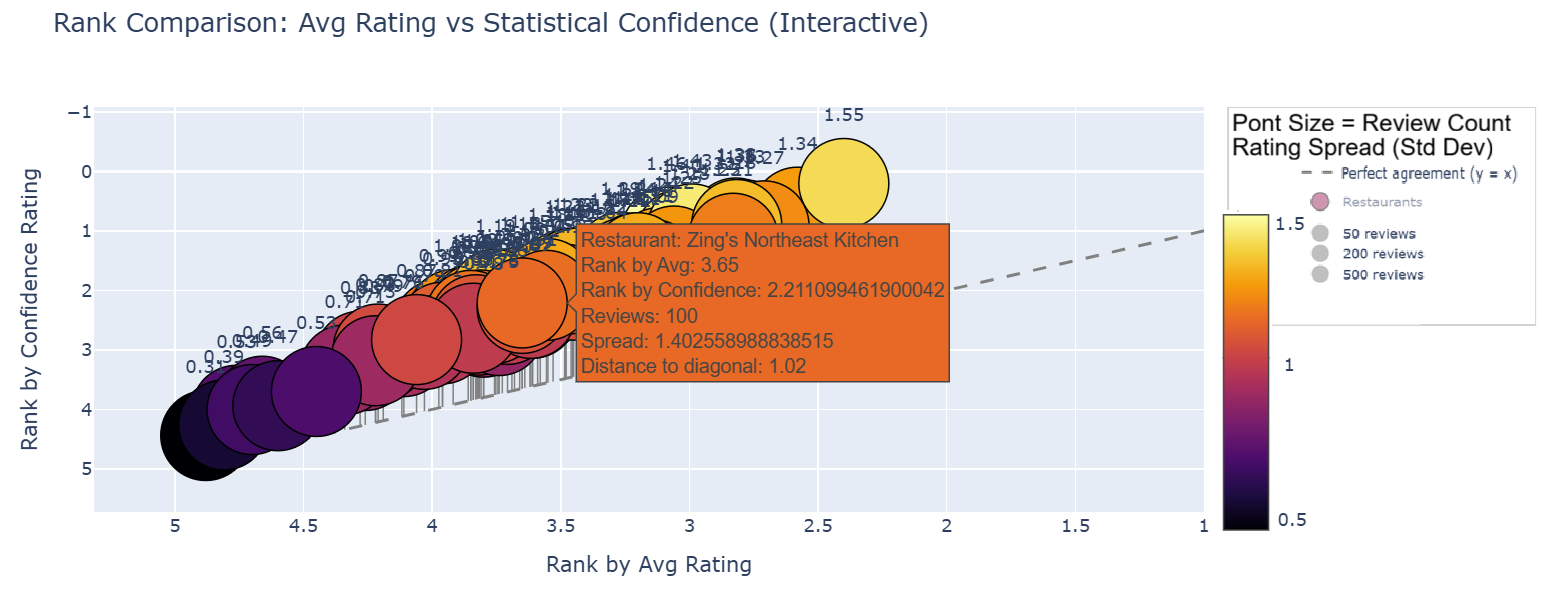

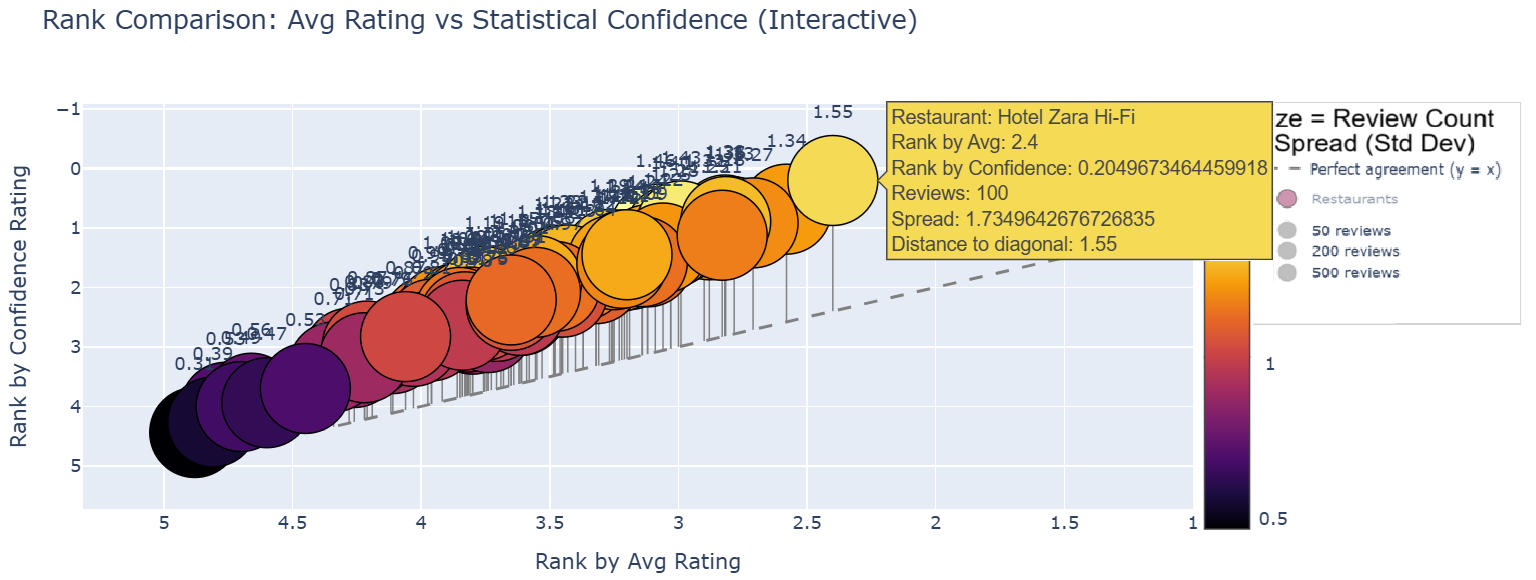

In [ ]:
# Rank correlation metrics - Spearman’s ρ (To measure how similar two rankings,
# i.e. ranks on average_ratings and ranks on confidence are)

# To explain that restaurant ranking is not just based on average numeric ratings but review count, and rating spread as well.

from scipy.stats import spearmanr
import plotly.express as px

rho, p_value = spearmanr(rank_avg, rank_conf)

print(f"Spearman's ρ: {rho:.3f}")
print(f"p-value: {p_value:.3f}")

corr_df = pd.DataFrame(
    [[1, rho],
     [rho, 1]],
    index=["Rank by Avg", "Rank by Confidence"],
    columns=["Rank by Avg", "Rank by Confidence"]
)

fig = px.imshow(
    corr_df,
    text_auto=".2f",
    color_continuous_scale="RdBu",
    zmin=-1, zmax=1,
    title=f"Spearman Rank Correlation (ρ = {rho:.2f})"
)

fig.update_coloraxes(colorbar_title="Correlation")
fig.show()

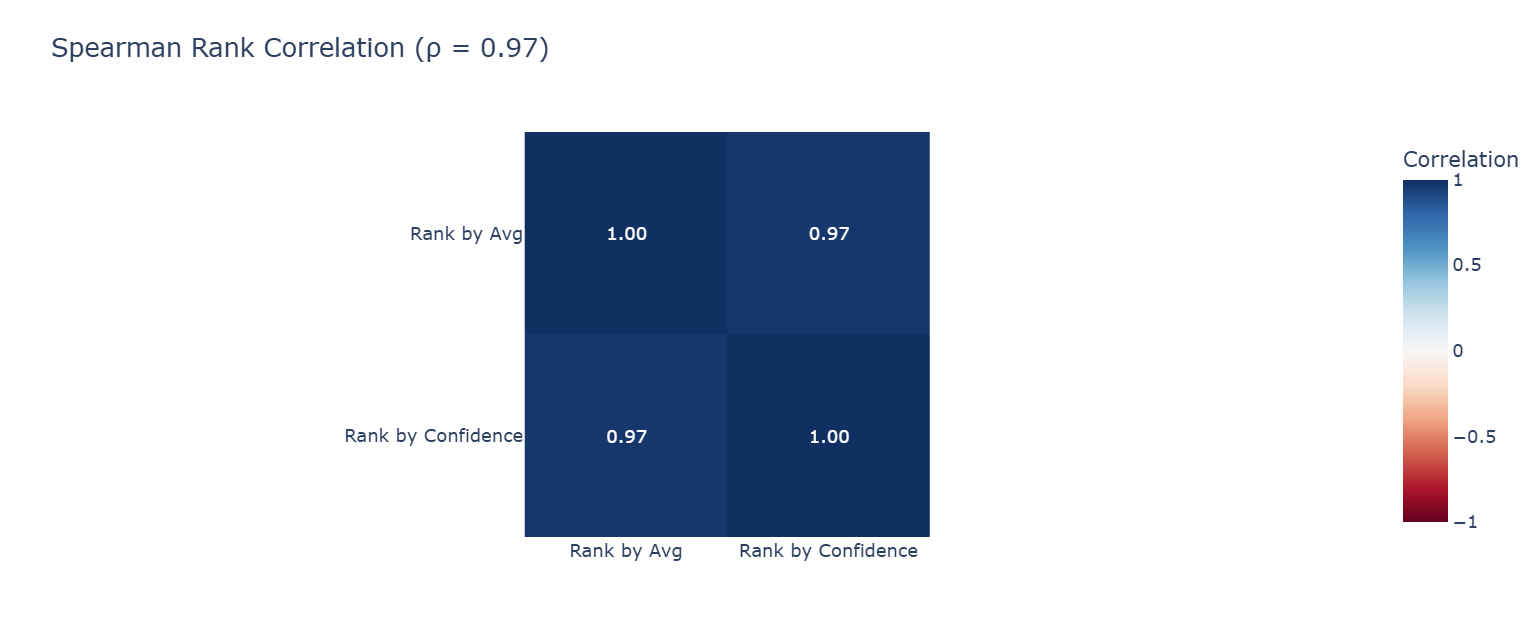